In [9]:
# @title Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

In [2]:
# @title Define some constants
max_words = 10000
max_sequence_length = 500
embedding_dim = 300
hidden_units = 128
vocab_size = max_words

In [3]:
# @title Load IMDB dataset from Keras (NOTE:Keras dataset is already quite clean and hence we don't need to do any further cleaning)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=max_words)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25000, 500)
(25000,)
(25000, 500)
(25000,)


In [5]:
# @title Attention Layer blueprint
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros")
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="normal")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        return tf.reduce_sum(x * tf.expand_dims(ait, -1), axis=1)

In [6]:
# @title download glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip

--2024-11-06 02:34:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-06 02:34:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-06 02:34:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(imdb.get_word_index())  # Using the pre-defined word index from Keras

word_index = tokenizer.word_index
print("Word Index:", word_index)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Word Index: {'à': 1, 'amélie': 2, 'fawn': 3, 'tsukino': 4, 'nunnery': 5, 'sonja': 6, 'vani': 7, 'woods': 8, 'spiders': 9, 'hanging': 10, 'woody': 11, 'trawling': 12, "hold's": 13, 'comically': 14, 'localized': 15, 'disobeying': 16, "'royale": 17, "harpo's": 18, 'canet': 19, 'aileen': 20, 'acurately': 21, "diplomat's": 22, 'rickman': 23, 'arranged': 24, 'rumbustious': 25, 'familiarness': 26, "spider'": 27, 'hahahah': 28, "wood'": 29, 'transvestism': 30, "hangin'": 31, 'bringing': 32, 'seamier': 33, 'wooded': 34, 'bravora': 35, 'grueling': 36, 'wooden': 37, 'wednesday': 38, "'prix": 39, 'altagracia': 40, 'circuitry': 41, 'crotch': 42, 'busybody': 43, "tart'n'tangy": 44, 'burgade': 45, 'thrace': 46, "tom's": 47, 'snuggles': 48, 'francesco': 49, 'complainers': 50, 'templarios': 51, '272': 52, '273': 53, 'zaniacs': 54, '275': 55, 'consenting': 56, 'snuggled': 57, 'inanimate': 58, 'uality': 59, 'bronte': 60, 'errors': 61, 'dialogs': 62, "yomad

In [12]:
import numpy as np
GLOVE_FILE = f'glove.6B.{embedding_dim}d.txt'
embedding_index = {}
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

vocab_size = min(10000, len(word_index) + 1)  # +1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with GloVe vectors
for word, i in word_index.items():
    if i < vocab_size:  # Ensure that we don't exceed the max vocabulary size
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Check the shape of the embedding matrix
print(f"Embedding Matrix Shape: {embedding_matrix.shape}")
# # Create embedding matrix
# embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embedding_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector


Embedding Matrix Shape: (10000, 300)


In [13]:
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(input_layer)

lstm_layer = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(embedding_layer)
attention_layer = AttentionLayer()(lstm_layer)
dropout_layer = Dropout(0.5)(attention_layer)
dense_layer = Dense(hidden_units, activation='relu')(dropout_layer)
dropout_layer_2 = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# @title Training and Evaluation
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 94ms/step - accuracy: 0.5916 - loss: 0.6542 - val_accuracy: 0.7556 - val_loss: 0.4955
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.7958 - loss: 0.4419 - val_accuracy: 0.7821 - val_loss: 0.4551
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 72s 96ms/step - accuracy: 0.8303 - loss: 0.3771 - val_accuracy: 0.8264 - val_loss: 0.3800
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 123ms/step - accuracy: 0.8729 - loss: 0.3086 - val_accuracy: 0.8493 - val_loss: 0.3386
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 72s 97ms/step - accuracy: 0.8960 - loss: 0.2635 - val_accuracy: 0.8431 - val_loss: 0.3655
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8433 - loss: 0.3632
Test Accuracy: 0.8430799841880798


782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step


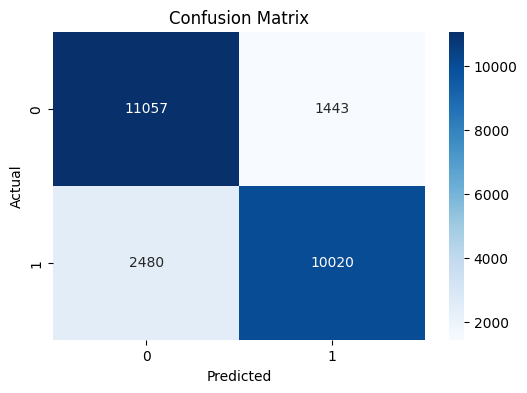

              precision    recall  f1-score   support

    Negative       0.82      0.88      0.85     12500
    Positive       0.87      0.80      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Performance Metrics
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print(report)


In [16]:
# Extract values from confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Compute metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.8741
Recall: 0.8016
Accuracy: 0.8431
F1 Score: 0.8363


In [17]:
# @title Save the trained model
save_path = "" # @param {"type":"string","placeholder":"/content/imdb_model.keras"}
model.save("/content/imdb_mmodel.keras")


In [18]:
# @title Install Necessary Libraries
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [ ]:
# @title Import libraries for inferencing and creating Gradio UI and some preprocessing of input text
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from html import unescape
import re


In [ ]:
# @title custom Methods
def preprocess_text(text):
    text = unescape(text)
    text = re.sub('<.*?>', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text

def predict_sentiment(text):
    processed_text = preprocess_text(text)
    sequence = tf.keras.preprocessing.text.text_to_word_sequence(processed_text)
    sequence = [word_index.get(word, 0) for word in sequence if word_index.get(word, 0) < max_words]  # Correct vocabulary
    padded_sequence = pad_sequences([sequence], maxlen=max_sequence_length)
    prediction = loaded_model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return {
        "Sentiment": sentiment,
        "Positive Probability": f"{prediction:.4f}",
        "Negative Probability": f"{1 - prediction:.4f}"
    }


In [ ]:
# @title model loading and inference
# Load your trained model (REPLACE with your actual model path)
loaded_model = tf.keras.models.load_model(save_path, custom_objects={'AttentionLayer': AttentionLayer})  # Update path and custom_objects

# Load the IMDB word index
word_index = tf.keras.datasets.imdb.get_word_index()

# Gradio Interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=10, placeholder="Enter your movie review here..."),
    outputs=gr.JSON(),
    title="Movie Review Sentiment Analysis",
    description="Enter a movie review to analyze its sentiment.  HTML tags and entities are handled.",
    examples=[
        ["This movie was fantastic! The acting and direction were superb. <br> I highly recommend it."],
        ["I absolutely hated this film. It was a complete waste of time. <sarcasm>Great job!</sarcasm>"],
        ["The movie was okay, I guess. Nothing too special."]
    ]
)

iface.launch(debug=True) # Or share=True for a shareable Colab link

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e77b338bef0a1de366.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e77b338bef0a1de366.gradio.live
